In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_parquet("../data/transactions.parquet" )
df_clean = df.loc[df['is_fraud']]

In [4]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [5]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [6]:
from utils import create_customer_merchant_multigraph

In [7]:
G = create_customer_merchant_multigraph(df)


Graph created: 1666 nodes, 1296675 edges.


In [8]:
from model import GraphCNNSequential, AdvancedGraphCNN
from dataloader import  SubgraphDataset


In [9]:

# For nodes, get the 'type_onehot' attribute
node_feature_config = {
    "type": lambda data: np.array(data["type_onehot"])
    # "type": lambda data: np.array([2])
}

# For edges, get the 'amt' attribute and put it in a list
edge_feature_config = {
    "amount": lambda data: np.array([data['amt']]),
    # "time": lambda data: [float(data.get('unix_time', 0.0)) / 1e9] # Normalized
}
print("Initializing SubgraphDataset...")
dataset = SubgraphDataset(
    G=G,
    node_feature_config=node_feature_config,
    edge_feature_config=edge_feature_config,
    num_samples=len(df),
    walk_length=50,
    num_walks=2,
    max_subgraph_size=100
)

# 3. Get a sample
print("\nFetching sample data (idx=0, fraudulent)...")
sample_data_fraud = dataset.get(0)
print(sample_data_fraud)
print(f"Node features (x) shape: {sample_data_fraud.x.shape}")
print(f"Edge features (edge_attr) shape: {sample_data_fraud.edge_attr.shape}")
print(f"Graph label (y): {sample_data_fraud.y}")


print("\nFetching sample data (idx=1, non-fraudulent)...")
sample_data_non_fraud = dataset.get(1)
print(sample_data_non_fraud)
print(f"Node features (x) shape: {sample_data_non_fraud.x.shape}")
print(f"Edge features (edge_attr) shape: {sample_data_non_fraud.edge_attr.shape}")
print(f"Graph label (y): {sample_data_non_fraud.y}")

Initializing SubgraphDataset...
Initialized dataset. Node features dim: 2. Edge features dim: 1.

Fetching sample data (idx=0, fraudulent)...
Data(x=[100, 2], edge_index=[2, 98], edge_attr=[98, 1], y=[1], edge_label=[98])
Node features (x) shape: torch.Size([100, 2])
Edge features (edge_attr) shape: torch.Size([98, 1])
Graph label (y): tensor([1.])

Fetching sample data (idx=1, non-fraudulent)...
Data(x=[100, 2], edge_index=[2, 99], edge_attr=[99, 1], y=[1], edge_label=[99])
Node features (x) shape: torch.Size([100, 2])
Edge features (edge_attr) shape: torch.Size([99, 1])
Graph label (y): tensor([0.])


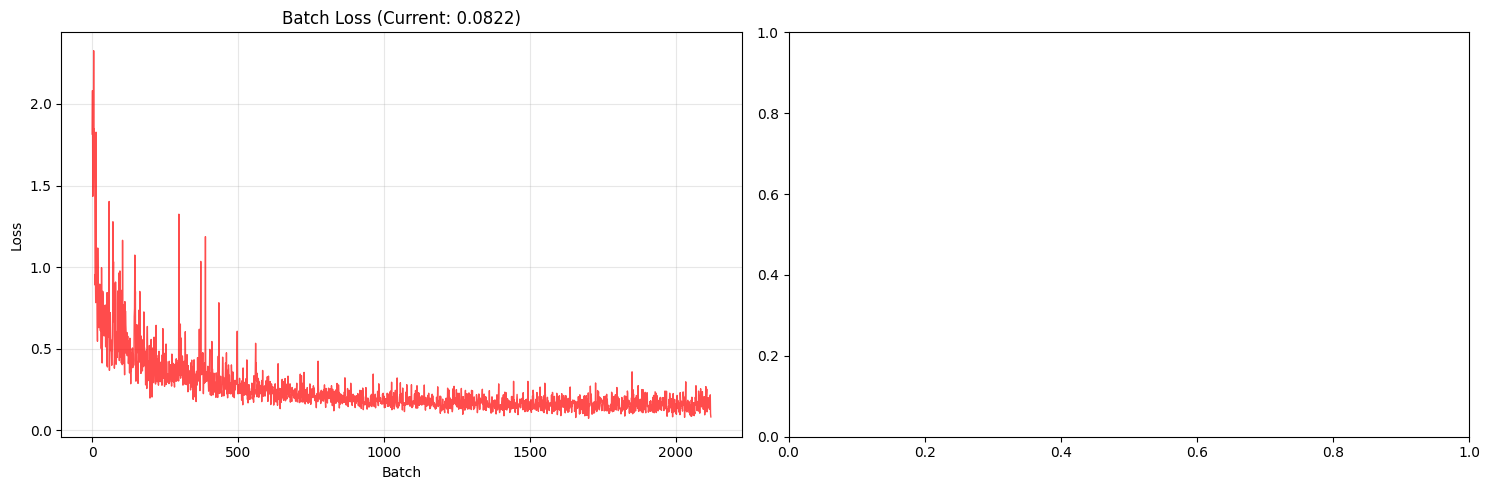

Epoch 0, Batch 2120, Loss: 0.0822


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from torch_geometric.data import DataLoader

# Create data loader
loader = DataLoader(dataset, batch_size=24, shuffle=True)

# Initialize model
model = AdvancedGraphCNN(node_dim=2, edge_dim=1, hidden_dim=128, num_layers=4)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Setup for plotting
batch_losses = []
epoch_losses = []

# Training loop
model.train()
for epoch in range(20):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, batch in enumerate(loader):
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.item()
        batch_losses.append(current_loss)
        epoch_loss += current_loss
        num_batches += 1
        
        # Update plot every 5 batches
        if batch_idx % 5 == 0:
            clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Batch loss plot
            ax1.plot(batch_losses, 'r-', alpha=0.7, linewidth=1)
            ax1.set_xlabel('Batch')
            ax1.set_ylabel('Loss')
            ax1.set_title(f'Batch Loss (Current: {current_loss:.4f})')
            ax1.grid(True, alpha=0.3)
            
            # Epoch loss plot
            if epoch_losses:
                ax2.plot(range(1, len(epoch_losses) + 1), epoch_losses, 'b-', linewidth=2)
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Average Loss')
                ax2.set_title('Epoch Average Loss')
                ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {current_loss:.4f}")
    
    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch} completed. Average Loss: {avg_epoch_loss:.4f}")

print("Training completed!")